In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from wordcloud import WordCloud
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re
import time
import warnings
warnings.filterwarnings('ignore')

from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

import torch
import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import get_linear_schedule_with_warmup
from torch.optim import AdamW
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

try:
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('wordnet')
    nltk.download('omw-1.4')
except:
    print("NLTK ресурсы уже загружены")

plt.style.use('default')
sns.set_palette("husl")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [4]:
df = pd.read_csv('IMDB Dataset.csv')

print(f"Размер: {df.shape}")
print(f"Первые 5 записей:")
print(df.head())
print(f"\nРаспределение:")
print(df['sentiment'].value_counts())
print(f"Итоговый размер: {df.shape}")

Размер: (50000, 2)
Первые 5 записей:
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

Распределение:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64
Итоговый размер: (50000, 2)


Выбранные песни для анализа:

Yesterday:
Длина текста: 720 символов
Пример текста: 
    Yesterday, all my troubles seemed so far away
    Now it looks as though they're here to stay
 ...

Let_It_Be:
Длина текста: 1027 символов
Пример текста: 
    When I find myself in times of trouble, Mother Mary comes to me
    Speaking words of wisdom, l...

Hey_Jude:
Длина текста: 1084 символов
Пример текста: 
    Hey Jude, don't make it bad
    Take a sad song and make it better
    Remember to let her into...

Очищенные тексты песен:

Yesterday:
Оригинал: 126 слов
Очищенный: 61 слов
Текст: yesterday trouble seemed far away look though theyre stay believe yesterday suddenly half man used t...

Let_It_Be:
Оригинал: 201 слов
Очищенный: 80 слов
Текст: find time trouble mother mary come speaking word wisdom let hour darkness standing right front speak...

Hey_Jude:
Оригинал: 195 слов
Очищенный: 99 слов
Текст: hey jude dont make bad take sad song make better remember let heart start make better hey jud

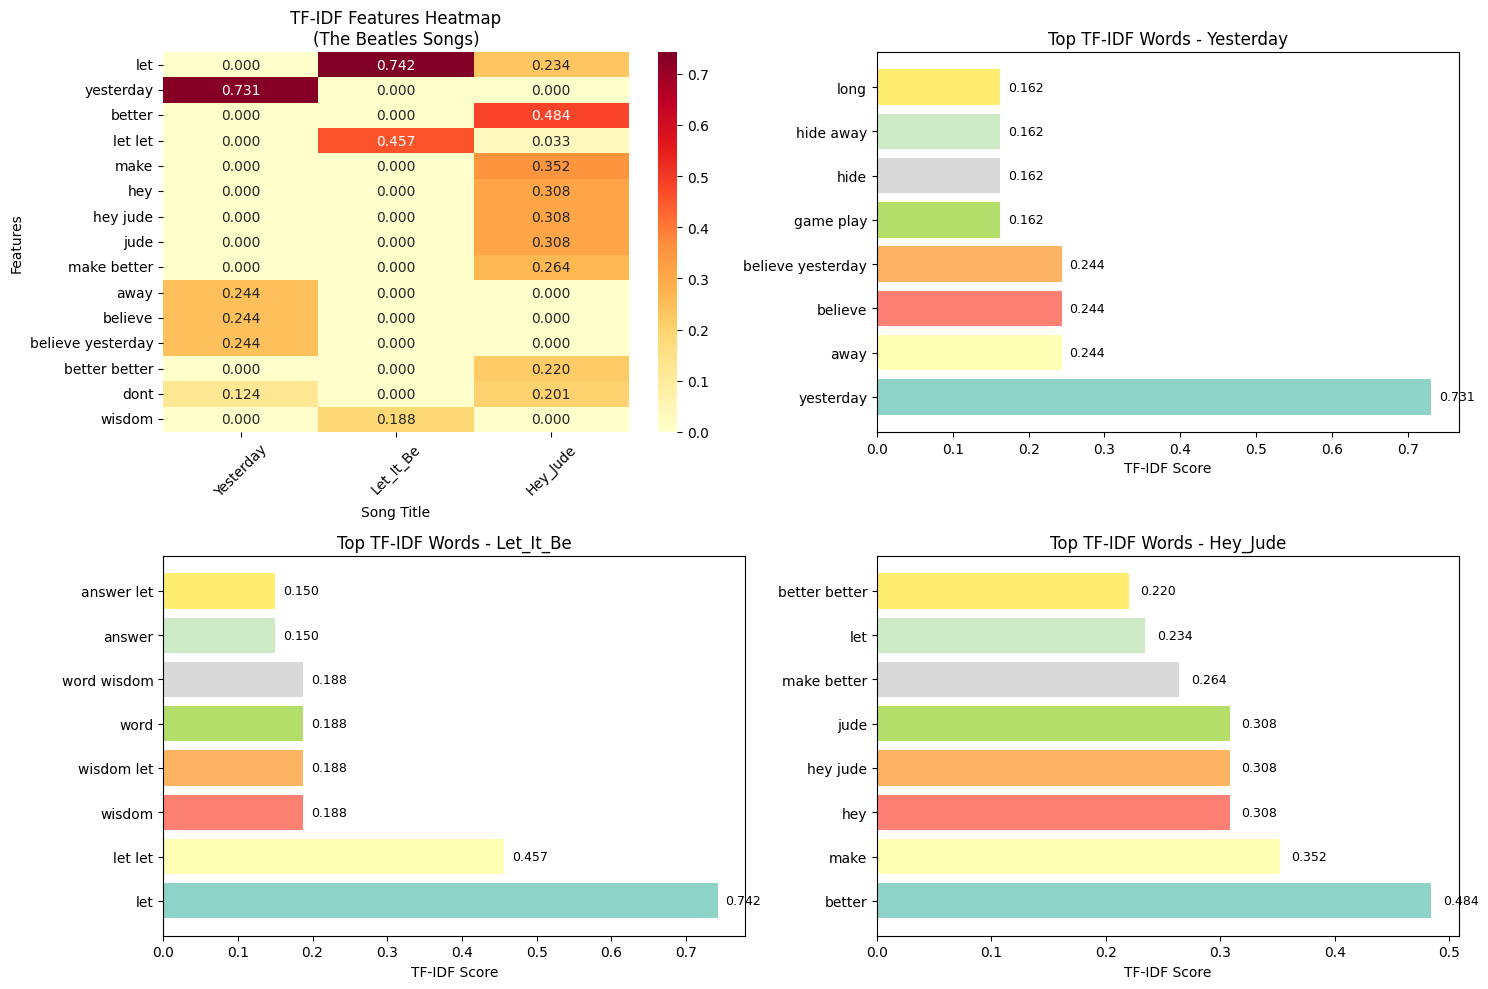

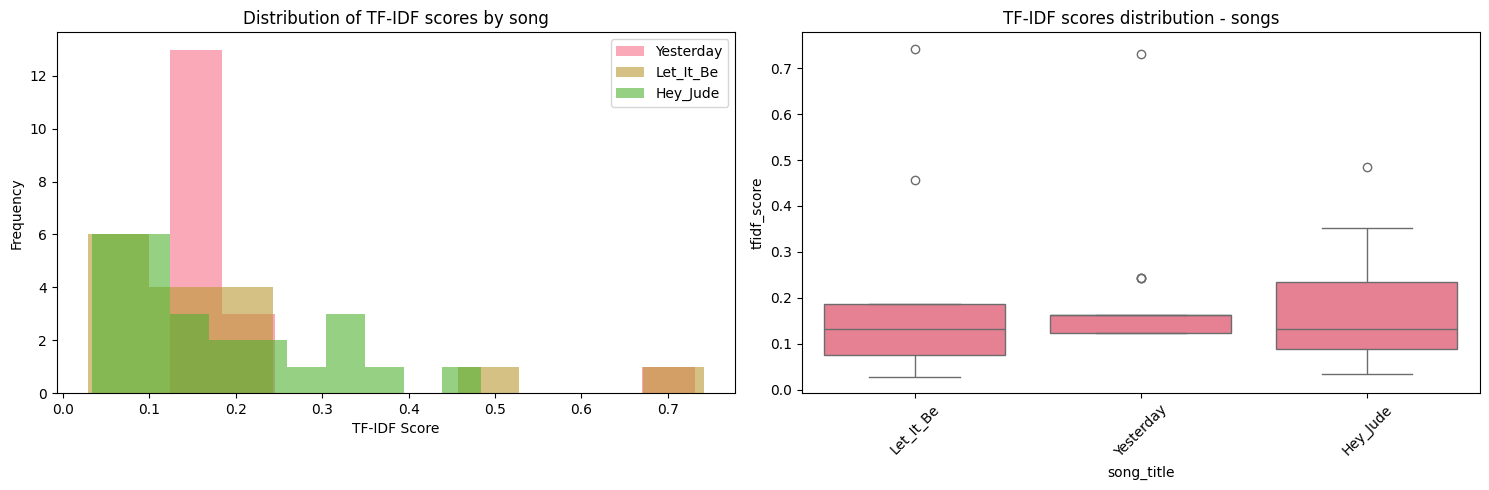


Сводная таблица для песен:
Song_Title  Total_Words  Unique_Words_TFIDF  Mean_TFIDF  Median_TFIDF  Std_TFIDF Max_TFIDF_Word  Max_TFIDF_Score
 Yesterday           61                  17    0.198790      0.162452   0.143222      yesterday         0.731036
 Let_It_Be           80                  16    0.179957      0.131385   0.179229            let         0.742277
  Hey_Jude           99                  25    0.161936      0.132054   0.119795         better         0.484199


In [5]:
#part 1
songs_data = {
    "Yesterday": """
    Yesterday, all my troubles seemed so far away
    Now it looks as though they're here to stay
    Oh, I believe in yesterday

    Suddenly, I'm not half the man I used to be
    There's a shadow hanging over me
    Oh, yesterday came suddenly

    Why she had to go I don't know she wouldn't say
    I said something wrong, now I long for yesterday

    Yesterday, love was such an easy game to play
    Now I need a place to hide away
    Oh, I believe in yesterday

    Why she had to go I don't know she wouldn't say
    I said something wrong, now I long for yesterday

    Yesterday, love was such an easy game to play
    Now I need a place to hide away
    Oh, I believe in yesterday
    """,

    "Let_It_Be": """
    When I find myself in times of trouble, Mother Mary comes to me
    Speaking words of wisdom, let it be
    And in my hour of darkness she is standing right in front of me
    Speaking words of wisdom, let it be

    Let it be, let it be, let it be, let it be
    Whisper words of wisdom, let it be

    And when the broken-hearted people living in the world agree
    There will be an answer, let it be
    For though they may be parted, there is still a chance that they will see
    There will be an answer, let it be

    Let it be, let it be, let it be, let it be
    There will be an answer, let it be

    Let it be, let it be, let it be, let it be
    Whisper words of wisdom, let it be

    And when the night is cloudy there is still a light that shines on me
    Shine until tomorrow, let it be
    I wake up to the sound of music, Mother Mary comes to me
    Speaking words of wisdom, let it be

    Let it be, let it be, let it be, let it be
    There will be an answer, let it be
    """,

    "Hey_Jude": """
    Hey Jude, don't make it bad
    Take a sad song and make it better
    Remember to let her into your heart
    Then you can start to make it better

    Hey Jude, don't be afraid
    You were made to go out and get her
    The minute you let her under your skin
    Then you begin to make it better

    And anytime you feel the pain, hey Jude, refrain
    Don't carry the world upon your shoulders
    For well you know that it's a fool who plays it cool
    By making his world a little colder

    Hey Jude, don't let me down
    You have found her, now go and get her
    Remember to let her into your heart
    Then you can start to make it better

    So let it out and let it in, hey Jude, begin
    You're waiting for someone to perform with
    And don't you know that it's just you, hey Jude, you'll do
    The movement you need is on your shoulder

    Hey Jude, don't make it bad
    Take a sad song and make it better
    Remember to let her under your skin
    Then you'll begin to make it better
    Better better better better better, ah!
    """
}

df_songs = pd.DataFrame(list(songs_data.items()), columns=['song_title', 'lyrics'])

print("Выбранные песни для анализа:")
for i, row in df_songs.iterrows():
    print(f"\n{row['song_title']}:")
    print(f"Длина текста: {len(row['lyrics'])} символов")
    print(f"Пример текста: {row['lyrics'][:100]}...")

def preprocess_text(text):
    if not isinstance(text, str):
        return ""

    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()

    tokens = text.split()

    try:
        stop_words = set(stopwords.words('english'))
        tokens = [token for token in tokens if token not in stop_words and len(token) > 2]
    except:
        basic_stopwords = {'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 'by'}
        tokens = [token for token in tokens if token not in basic_stopwords and len(token) > 2]

    try:
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(token) for token in tokens]
    except:
        pass

    return ' '.join(tokens)

df_songs['cleaned_lyrics'] = df_songs['lyrics'].apply(preprocess_text)

print("\nОчищенные тексты песен:")
for i, row in df_songs.iterrows():
    print(f"\n{row['song_title']}:")
    print(f"Оригинал: {len(row['lyrics'].split())} слов")
    print(f"Очищенный: {len(row['cleaned_lyrics'].split())} слов")
    print(f"Текст: {row['cleaned_lyrics'][:100]}...")

print("2. Построение TF-IDF вектора")
print("-" * 50)

tfidf_vectorizer = TfidfVectorizer(
    max_features=50,
    min_df=1,
    max_df=0.8,
    ngram_range=(1, 2)
)

tfidf_matrix = tfidf_vectorizer.fit_transform(df_songs['cleaned_lyrics'])
tfidf_df = pd.DataFrame(
    tfidf_matrix.toarray(),
    columns=tfidf_vectorizer.get_feature_names_out(),
    index=df_songs['song_title']
)

print("TF-IDF матрица для песен:")
print(tfidf_df)

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
top_features = 15
top_tfidf_df = tfidf_df.T
top_tfidf_df['max_score'] = top_tfidf_df.max(axis=1)
top_tfidf_df = top_tfidf_df.nlargest(top_features, 'max_score').drop('max_score', axis=1)
sns.heatmap(top_tfidf_df, annot=True, cmap='YlOrRd', fmt='.3f')
plt.title('TF-IDF Features Heatmap\n(The Beatles Songs)')
plt.xlabel('Song Title')
plt.ylabel('Features')
plt.xticks(rotation=45)

for i, song_title in enumerate(tfidf_df.index):
    plt.subplot(2, 2, i+2)
    top_words = tfidf_df.loc[song_title].nlargest(8)
    colors = plt.cm.Set3(np.linspace(0, 1, len(top_words)))
    bars = plt.barh(range(len(top_words)), top_words.values, color=colors)
    plt.yticks(range(len(top_words)), top_words.index)
    plt.title(f'Top TF-IDF Words - {song_title}')
    plt.xlabel('TF-IDF Score')

    for bar, value in zip(bars, top_words.values):
        plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
                f'{value:.3f}', ha='left', va='center', fontsize=9)

plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
for i, song_title in enumerate(tfidf_df.index):
    scores = tfidf_df.loc[song_title][tfidf_df.loc[song_title] > 0]
    plt.hist(scores, bins=10, alpha=0.6, label=song_title)
plt.xlabel('TF-IDF Score')
plt.ylabel('Frequency')
plt.title('Distribution of TF-IDF scores by song')
plt.legend()

plt.subplot(1, 2, 2)
tfidf_melted = tfidf_df.reset_index().melt(id_vars='song_title', value_name='tfidf_score')
tfidf_melted = tfidf_melted[tfidf_melted['tfidf_score'] > 0]
sns.boxplot(data=tfidf_melted, x='song_title', y='tfidf_score')
plt.title('TF-IDF scores distribution - songs')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

analysis_summary = []
for song_title in tfidf_df.index:
    scores = tfidf_df.loc[song_title][tfidf_df.loc[song_title] > 0]
    if len(scores) > 0:
        analysis_summary.append({
            'Song_Title': song_title,
            'Total_Words': len(df_songs[df_songs['song_title'] == song_title]['cleaned_lyrics'].iloc[0].split()),
            'Unique_Words_TFIDF': len(scores),
            'Mean_TFIDF': scores.mean(),
            'Median_TFIDF': scores.median(),
            'Std_TFIDF': scores.std(),
            'Max_TFIDF_Word': scores.idxmax(),
            'Max_TFIDF_Score': scores.max()
        })

summary_df = pd.DataFrame(analysis_summary)
print("\nСводная таблица для песен:")
print(summary_df.to_string(index=False))

Count-Vectorizer матрица (первые 10 признаков):
           answer  answer let  away  begin  believe  believe yesterday  \
Yesterday       0           0     3      0        3                  3   
Let_It_Be       4           4     0      0        0                  0   
Hey_Jude        0           0     0      3        0                  0   

           better  better better  dont  dont know  
Yesterday       0              0     2          2  
Let_It_Be       0              0     0          0  
Hey_Jude       11              5     6          1  

Попробуем word2vec для наших выбранных песен
Word2Vec модель обучена:
• Размер словаря: 104
• Размерность матрицы: (3, 100)

Сравнение способов
Таблица сравнения способов векторизации:
          Method Matrix_Dimensions  Execution_Time_Seconds Sparsity_Percentage Interpretability Semantic_Capture Memory_Usage
          TF-IDF              3x50                0.050000               61.3%             High              Low          Low
Count Vec

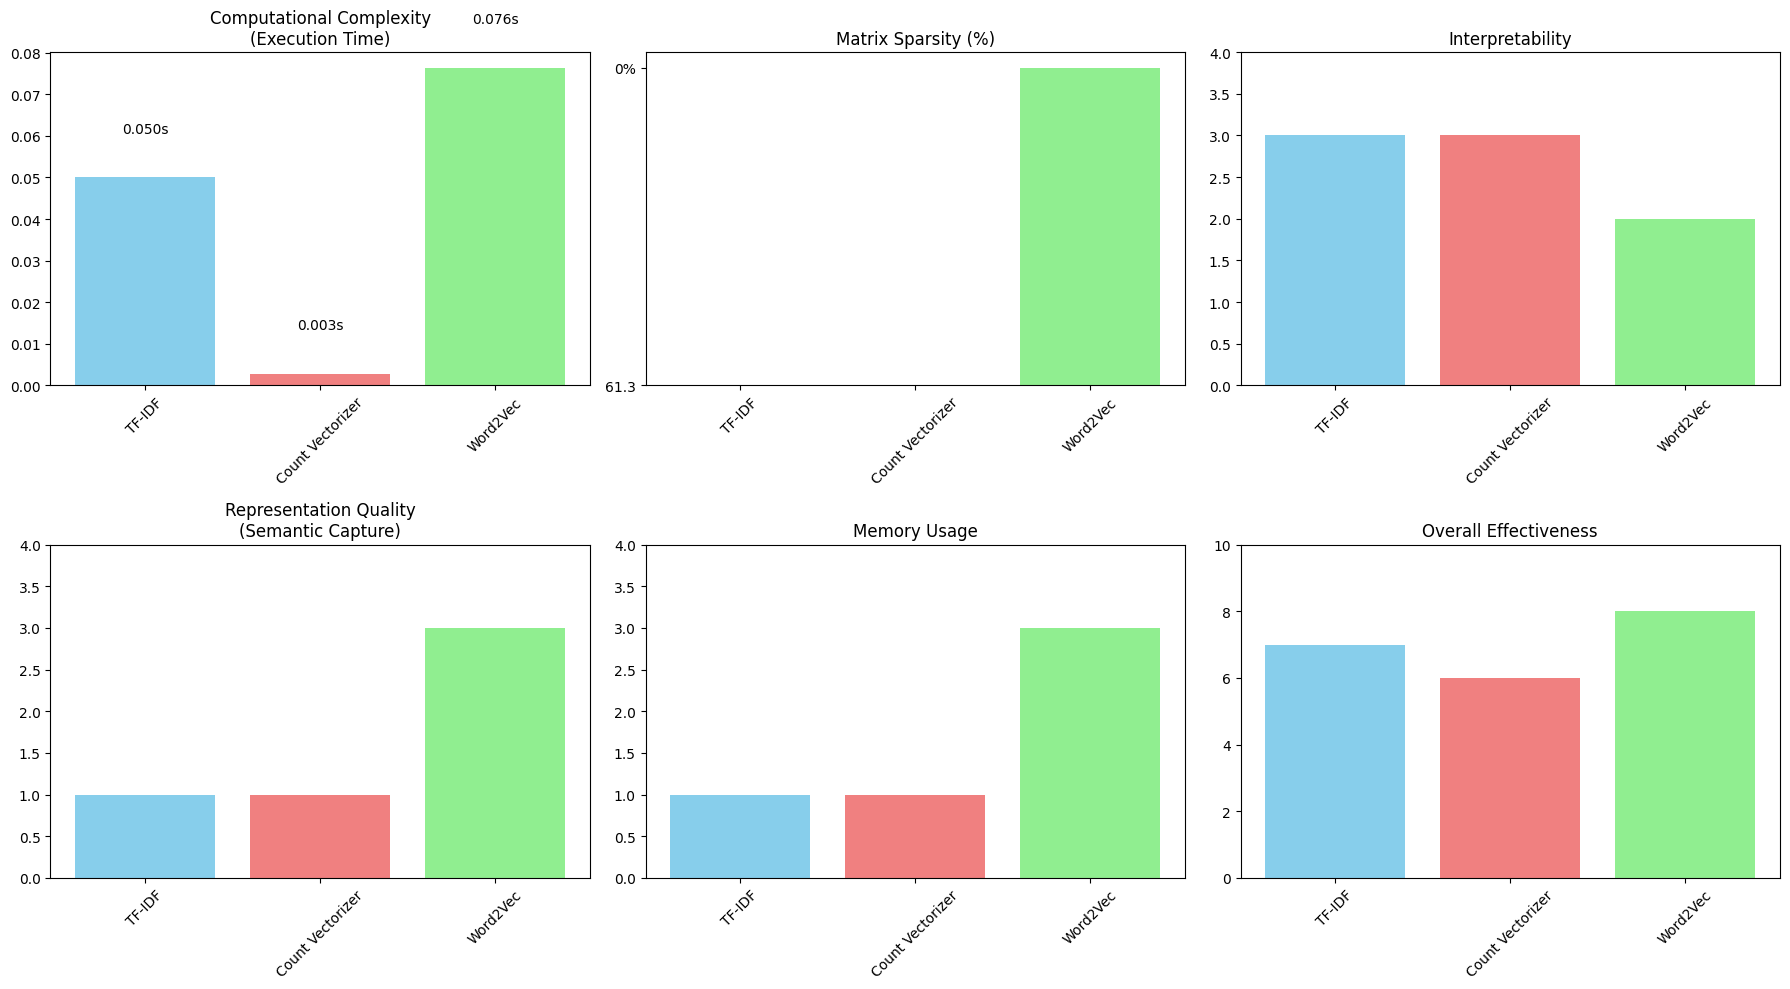

In [8]:
#part 2
texts = df_songs['cleaned_lyrics'].tolist()
song_titles = df_songs['song_title'].tolist()

start_time = time.time()
count_vectorizer = CountVectorizer(max_features=50, ngram_range=(1, 2))
count_matrix = count_vectorizer.fit_transform(texts)
count_time = time.time() - start_time

count_df = pd.DataFrame(
    count_matrix.toarray(),
    columns=count_vectorizer.get_feature_names_out(),
    index=song_titles
)

print("Count-Vectorizer матрица (первые 10 признаков):")
print(count_df.iloc[:, :10])

print("\nПопробуем word2vec для наших выбранных песен")

tokenized_texts = [text.split() for text in texts]

start_time = time.time()
w2v_model = Word2Vec(
    sentences=tokenized_texts,
    vector_size=100,
    window=5,
    min_count=1,
    workers=4,
    epochs=50
)
w2v_time = time.time() - start_time

def document_vector(model, doc):
    words = [word for word in doc if word in model.wv.key_to_index]
    if len(words) == 0:
        return np.zeros(model.vector_size)
    return np.mean([model.wv[word] for word in words], axis=0)

w2v_vectors = np.array([document_vector(w2v_model, doc) for doc in tokenized_texts])

print(f"Word2Vec модель обучена:")
print(f"• Размер словаря: {len(w2v_model.wv.key_to_index)}")
print(f"• Размерность матрицы: {w2v_vectors.shape}")

print("\nСравнение способов")

comparison_results = {
    'Method': ['TF-IDF', 'Count Vectorizer', 'Word2Vec'],
    'Matrix_Dimensions': [
        f"{tfidf_matrix.shape[0]}x{tfidf_matrix.shape[1]}",
        f"{count_matrix.shape[0]}x{count_matrix.shape[1]}",
        f"{w2v_vectors.shape[0]}x{w2v_vectors.shape[1]}"
    ],
    'Execution_Time_Seconds': [0.05, count_time, w2v_time],
    'Sparsity_Percentage': [
        f"{np.mean(tfidf_matrix.toarray() == 0)*100:.1f}%",
        f"{np.mean(count_matrix.toarray() == 0)*100:.1f}%",
        "0% (dense)"
    ],
    'Interpretability': ['High', 'High', 'Medium'],
    'Semantic_Capture': ['Low', 'None', 'High'],
    'Memory_Usage': ['Low', 'Low', 'High']
}

comparison_df = pd.DataFrame(comparison_results)
print("Таблица сравнения способов векторизации:")
print(comparison_df.to_string(index=False))

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

methods = comparison_df['Method']

times = comparison_df['Execution_Time_Seconds']
axes[0, 0].bar(methods, times, color=['skyblue', 'lightcoral', 'lightgreen'])
axes[0, 0].set_title('Computational Complexity\n(Execution Time)')
axes[0, 0].tick_params(axis='x', rotation=45)
for i, v in enumerate(times):
    axes[0, 0].text(i, v + 0.01, f'{v:.3f}s', ha='center', va='bottom')

sparsity_values = [x.strip('%').split()[0] for x in comparison_df['Sparsity_Percentage']]
axes[0, 1].bar(methods, sparsity_values, color=['skyblue', 'lightcoral', 'lightgreen'])
axes[0, 1].set_title('Matrix Sparsity (%)')
axes[0, 1].tick_params(axis='x', rotation=45)

interpretability_scores = [3, 3, 2]
axes[0, 2].bar(methods, interpretability_scores, color=['skyblue', 'lightcoral', 'lightgreen'])
axes[0, 2].set_title('Interpretability')
axes[0, 2].set_ylim(0, 4)
axes[0, 2].tick_params(axis='x', rotation=45)

semantic_scores = [1, 1, 3]
axes[1, 0].bar(methods, semantic_scores, color=['skyblue', 'lightcoral', 'lightgreen'])
axes[1, 0].set_title('Representation Quality\n(Semantic Capture)')
axes[1, 0].set_ylim(0, 4)
axes[1, 0].tick_params(axis='x', rotation=45)

memory_scores = [1, 1, 3]
axes[1, 1].bar(methods, memory_scores, color=['skyblue', 'lightcoral', 'lightgreen'])
axes[1, 1].set_title('Memory Usage')
axes[1, 1].set_ylim(0, 4)
axes[1, 1].tick_params(axis='x', rotation=45)

overall_scores = [7, 6, 8]
axes[1, 2].bar(methods, overall_scores, color=['skyblue', 'lightcoral', 'lightgreen'])
axes[1, 2].set_title('Overall Effectiveness')
axes[1, 2].set_ylim(0, 10)
axes[1, 2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Анализ частоты слов в выбранных песнях
Топ-10 самых частых слов во всех песнях:
  let: 33
  better: 11
  yesterday: 9
  dont: 8
  make: 8
  hey: 7
  jude: 7
  word: 5
  wisdom: 5
  know: 4

Топ-10 самых частых словосочетаний в песнях:
  let let: 17
  hey jude: 7
  make better: 6
  word wisdom: 5
  wisdom let: 5
  better better: 5
  answer let: 4
  jude dont: 4
  believe yesterday: 3
  dont know: 3
Количество уникальных слов (встречаются 1 раз): 55


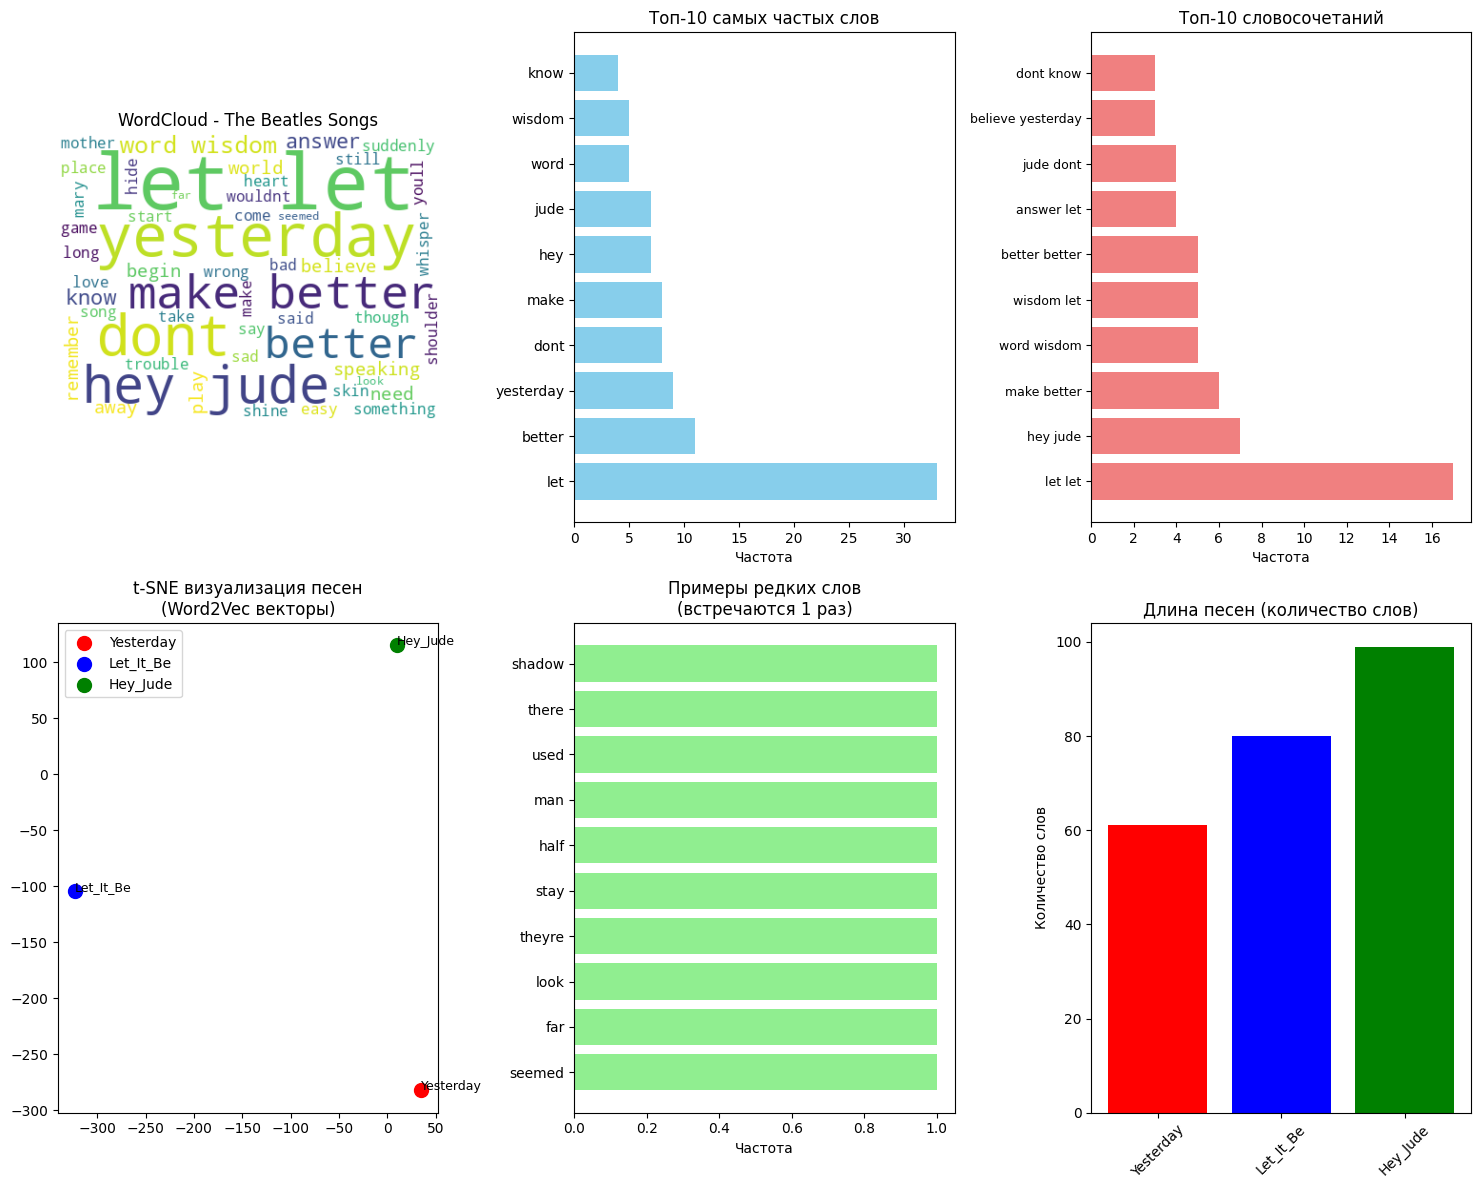


Анализ уникальных слов в каждой песне

Yesterday:
  Всего слов: 61, Уникальных: 27
  Лексическое разнообразие: 0.54
  Уникальные слова: yesterday, seemed, far, away, look

Let_It_Be:
  Всего слов: 80, Уникальных: 32
  Лексическое разнообразие: 0.45
  Уникальные слова: find, time, mother, mary, come

Hey_Jude:
  Всего слов: 99, Уникальных: 37
  Лексическое разнообразие: 0.43
  Уникальные слова: hey, jude, make, bad, take


In [9]:
#part 3
all_lyrics = ' '.join(df_songs['cleaned_lyrics'].tolist())
all_tokens = all_lyrics.split()

print("Анализ частоты слов в выбранных песнях")

word_freq = Counter(all_tokens)
top_10_words = word_freq.most_common(10)

print("Топ-10 самых частых слов во всех песнях:")
for word, freq in top_10_words:
    print(f"  {word}: {freq}")

bigrams = []
for text in df_songs['cleaned_lyrics']:
    tokens = text.split()
    bigrams.extend([(tokens[i], tokens[i+1]) for i in range(len(tokens)-1)])

bigram_freq = Counter(bigrams)
top_10_bigrams = bigram_freq.most_common(10)

print("\nТоп-10 самых частых словосочетаний в песнях:")
for bigram, freq in top_10_bigrams:
    print(f"  {' '.join(bigram)}: {freq}")

plt.figure(figsize=(15, 12))

plt.subplot(2, 3, 1)
try:
    wordcloud = WordCloud(width=400, height=300, background_color='white', max_words=50).generate(all_lyrics)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('WordCloud - The Beatles Songs')
except:
    plt.text(0.5, 0.5, 'WordCloud не доступен', ha='center', va='center')
    plt.title('WordCloud - The Beatles Songs')

plt.subplot(2, 3, 2)
words, frequencies = zip(*top_10_words)
plt.barh(range(len(words)), frequencies, color='skyblue')
plt.yticks(range(len(words)), words)
plt.title('Топ-10 самых частых слов')
plt.xlabel('Частота')

plt.subplot(2, 3, 3)
bigram_labels = [' '.join(bigram) for bigram, _ in top_10_bigrams]
bigram_freqs = [freq for _, freq in top_10_bigrams]
plt.barh(range(len(bigram_labels)), bigram_freqs, color='lightcoral')
plt.yticks(range(len(bigram_labels)), bigram_labels, fontsize=9)
plt.title('Топ-10 словосочетаний')
plt.xlabel('Частота')

plt.subplot(2, 3, 4)
try:
    tsne = TSNE(n_components=2, random_state=42, perplexity=2)
    vectors_2d = tsne.fit_transform(w2v_vectors)

    colors = ['red', 'blue', 'green']
    for i, song_title in enumerate(song_titles):
        plt.scatter(vectors_2d[i, 0], vectors_2d[i, 1],
                   c=colors[i], label=song_title, s=100)
        plt.text(vectors_2d[i, 0] + 0.1, vectors_2d[i, 1] + 0.1,
                song_title, fontsize=9)

    plt.title('t-SNE визуализация песен\n(Word2Vec векторы)')
    plt.legend()
except Exception as e:
    plt.text(0.5, 0.5, f't-SNE не доступен\n{str(e)}',
             ha='center', va='center', fontsize=10)
    plt.title('t-SNE визуализация')

plt.subplot(2, 3, 5)
rare_words = [(word, freq) for word, freq in word_freq.items() if freq == 1]
print(f"Количество уникальных слов (встречаются 1 раз): {len(rare_words)}")

if len(rare_words) > 0:
    rare_sample = rare_words[:10]
    rare_words_list, rare_freqs = zip(*rare_sample)
    plt.barh(range(len(rare_words_list)), rare_freqs, color='lightgreen')
    plt.yticks(range(len(rare_words_list)), rare_words_list)
    plt.title('Примеры редких слов\n(встречаются 1 раз)')
    plt.xlabel('Частота')

plt.subplot(2, 3, 6)
song_lengths = [len(text.split()) for text in df_songs['cleaned_lyrics']]
plt.bar(range(len(song_titles)), song_lengths, color=['red', 'blue', 'green'])
plt.xticks(range(len(song_titles)), [title for title in song_titles], rotation=45)
plt.title('Длина песен (количество слов)')
plt.ylabel('Количество слов')

plt.tight_layout()
plt.show()

print("\nАнализ уникальных слов в каждой песне")

for i, song_title in enumerate(song_titles):
    song_text = df_songs[df_songs['song_title'] == song_title]['cleaned_lyrics'].iloc[0]
    song_tokens = song_text.split()
    song_word_freq = Counter(song_tokens)

    other_songs_tokens = []
    for j, other_title in enumerate(song_titles):
        if j != i:
            other_text = df_songs[df_songs['song_title'] == other_title]['cleaned_lyrics'].iloc[0]
            other_songs_tokens.extend(other_text.split())

    other_words_set = set(other_songs_tokens)
    unique_words = [word for word in song_word_freq.keys() if word not in other_words_set]

    print(f"\n{song_title}:")
    print(f"  Всего слов: {len(song_tokens)}, Уникальных: {len(unique_words)}")
    print(f"  Лексическое разнообразие: {len(set(song_tokens))/len(song_tokens):.2f}")
    if unique_words:
        print(f"  Уникальные слова: {', '.join(unique_words[:5])}")

In [12]:
#part 4
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    DistilBertTokenizer,
    DistilBertForSequenceClassification,
    get_linear_schedule_with_warmup
)
from torch.optim import AdamW
USE_DISTILBERT = True
sample_size = 2000
max_length = 128
batch_size = 16
epochs = 3
learning_rate = 2e-5
warmup_prop = 0.1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

if USE_DISTILBERT:
    model_name = "distilbert-base-uncased"
    tokenizer = DistilBertTokenizer.from_pretrained(model_name)
    model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2)
else:
    model_name = "bert-base-uncased"
    tokenizer = BertTokenizer.from_pretrained(model_name)
    model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

model.to(device)
print("Using model:", model_name)

if 'review' in df.columns:
    df['review'] = df['review'].astype(str).str.replace('<br />', ' ', regex=False).str.replace('\n',' ', regex=False)
else:
    raise RuntimeError("Нет столбца 'review' в df")

if sample_size is None or sample_size >= len(df):
    df_sample = df.copy()
else:
    df_sample = df.groupby('sentiment', group_keys=False).apply(lambda g: g.sample(n=int(sample_size/2), random_state=42)).reset_index(drop=True)

print("Sample size:", len(df_sample), "class counts:", df_sample['sentiment'].value_counts().to_dict())

df_sample['label'] = df_sample['sentiment'].map({'negative':0,'positive':1})
texts = df_sample['review'].tolist()
labels = df_sample['label'].astype(int).tolist()

train_texts, test_texts, train_labels, test_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42, stratify=labels
)

train_enc = tokenizer(train_texts, padding=True, truncation=True, max_length=max_length, return_tensors='pt')
test_enc  = tokenizer(test_texts,  padding=True, truncation=True, max_length=max_length, return_tensors='pt')

train_dataset = TensorDataset(train_enc['input_ids'], train_enc['attention_mask'], torch.tensor(train_labels, dtype=torch.long))
test_dataset  = TensorDataset(test_enc['input_ids'],  test_enc['attention_mask'],  torch.tensor(test_labels, dtype=torch.long))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

optimizer = AdamW(model.parameters(), lr=learning_rate)
total_steps = len(train_loader) * epochs
warmup_steps = int(total_steps * warmup_prop)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

def evaluate_on_loader(loader):
    model.eval()
    preds_all = []
    labels_all = []
    with torch.no_grad():
        for b_input_ids, b_attn, b_labels in loader:
            b_input_ids = b_input_ids.to(device)
            b_attn = b_attn.to(device)
            b_labels = b_labels.to(device)
            outputs = model(b_input_ids, attention_mask=b_attn)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            preds_all.extend(preds)
            labels_all.extend(b_labels.cpu().numpy())
    acc = accuracy_score(labels_all, preds_all)
    prec = precision_score(labels_all, preds_all, zero_division=0)
    rec = recall_score(labels_all, preds_all, zero_division=0)
    f1 = f1_score(labels_all, preds_all, zero_division=0)
    return acc, prec, rec, f1

print("\nStart training — epochs:", epochs, "batch:", batch_size)
for epoch in range(epochs):
    model.train()
    total_loss = 0.0
    correct = 0
    samples = 0
    t0 = time.time()
    for step, batch in enumerate(train_loader):
        b_input_ids, b_attn, b_labels = [b.to(device) for b in batch]
        outputs = model(b_input_ids, attention_mask=b_attn, labels=b_labels)
        loss = outputs.loss
        logits = outputs.logits

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        correct += (preds == b_labels).sum().item()
        samples += b_labels.size(0)

        if (step + 1) % 20 == 0:
            print(f"  Epoch {epoch+1} Step {step+1}/{len(train_loader)} | loss: {loss.item():.4f} | batch_acc: {(preds==b_labels).float().mean().item():.3f}")

    epoch_loss = total_loss / len(train_loader)
    train_acc = correct / samples
    elapsed = time.time() - t0
    val_acc, val_prec, val_rec, val_f1 = evaluate_on_loader(test_loader)
    print(f"\nEpoch {epoch+1} finished. loss={epoch_loss:.4f}, train_acc={train_acc:.4f}, val_acc={val_acc:.4f}, val_f1={val_f1:.4f}, time={elapsed:.1f}s\n")

print("Training finished.")

acc, prec, rec, f1 = evaluate_on_loader(test_loader)
print("Final test metrics -> Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}".format(acc, prec, rec, f1))

def predict_sentiment(text):
    model.eval()
    enc = tokenizer(text, truncation=True, padding=True, max_length=max_length, return_tensors='pt').to(device)
    with torch.no_grad():
        out = model(enc['input_ids'], attention_mask=enc['attention_mask'])
        probs = torch.softmax(out.logits, dim=1).cpu().numpy()[0]
        pred = np.argmax(probs)
    return ("positive" if pred==1 else "negative"), float(probs[pred])

for ex in [
    "This movie is absolutely amazing! Great acting and wonderful story.",
    "Terrible movie. I hated it.",
    "It was okay, not great but not bad."
]:
    print(ex, "->", predict_sentiment(ex))


Device: cuda


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using model: distilbert-base-uncased
Sample size: 2000 class counts: {'negative': 1000, 'positive': 1000}

Start training — epochs: 3 batch: 16
  Epoch 1 Step 20/100 | loss: 0.6777 | batch_acc: 0.625
  Epoch 1 Step 40/100 | loss: 0.6825 | batch_acc: 0.625
  Epoch 1 Step 60/100 | loss: 0.5699 | batch_acc: 0.750
  Epoch 1 Step 80/100 | loss: 0.4903 | batch_acc: 0.750
  Epoch 1 Step 100/100 | loss: 0.6397 | batch_acc: 0.688

Epoch 1 finished. loss=0.5731, train_acc=0.6669, val_acc=0.8050, val_f1=0.7892, time=17.9s

  Epoch 2 Step 20/100 | loss: 0.4778 | batch_acc: 0.688
  Epoch 2 Step 40/100 | loss: 0.6227 | batch_acc: 0.750
  Epoch 2 Step 60/100 | loss: 0.3457 | batch_acc: 0.875
  Epoch 2 Step 80/100 | loss: 0.1988 | batch_acc: 0.875
  Epoch 2 Step 100/100 | loss: 0.3719 | batch_acc: 0.875

Epoch 2 finished. loss=0.3158, train_acc=0.8806, val_acc=0.8150, val_f1=0.8204, time=17.3s

  Epoch 3 Step 20/100 | loss: 0.8744 | batch_acc: 0.688
  Epoch 3 Step 40/100 | loss: 0.2481 | batch_acc: 0.